# S&P 500 Index Update Trading Strategies

## Strategy Overview

### Strategy 1: Long-Only Added Tickers
- **Capital**: $1,000,000 USD
- **Holding Period**: 30 days (configurable)
- **Entry**: Buy stocks added to S&P 500 on announcement date
- **Position Sizing**: Equal weight (1/N where N = number of concurrent positions)
- **Exit Rules**:
  - Hold for 30 days then sell
  - If new announcement comes before period ends: sell immediately and reallocate to new additions
- **Performance Metric**: Price_after_30_days / Price_at_announcement

### Strategy 2: Long/Short Pairs Trading
- **Capital**: $1,000,000 USD long + $1,000,000 USD short
- **Holding Period**: 30 days (configurable)
- **Entry**: Only trade when both Added and Removed tickers exist
  - Long: Added tickers (equal weight)
  - Short: Removed tickers (equal weight)
- **Exit Rules**: Same as Strategy 1
- **Note**: Only execute when announcement has both additions and removals

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load S&P 500 index changes data
df = pd.read_csv('./data/sp500_index_changes.csv')
df['Announcement_Date'] = pd.to_datetime(df['Announcement_Date'])
df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])

# Filter data from 2015 July onwards for sufficient data
df = df[df['Announcement_Date'] >= '2015-07-01'].reset_index(drop=True)
print(f"Number of index changes from 2015 July: {len(df)}")
df.head()

Number of index changes from 2015 July: 223


,Announcement_Date,Effective_Date,Added_Ticker,Added_Security,Removed_Ticker,Removed_Security,Reason
0,2025-07-18,2025-07-23,XYZ,"Block, Inc.",HES,Hess Corporation,S&P 500 and S&P 100 constituent Chevron Corp. ...
1,2025-07-14,2025-07-18,TTD,Trade Desk (The),ANSS,Ansys,S&P 500 constituent Synopsys Inc. acquired Ansys.
2,2025-07-02,2025-07-09,DDOG,Datadog,JNPR,Juniper Networks,S&P 500 constituent Hewlett Packard Enterprise...
3,2025-05-12,2025-05-19,COIN,Coinbase,DFS,Discover Financial,S&P 500 constituent Capital One Financial Corp...
4,2025-03-07,2025-03-24,DASH,DoorDash,BWA,BorgWarner,Market capitalization change.


In [11]:
# Strategy parameters
import os
import sys
import contextlib
from io import StringIO
from datetime import datetime as dt
import pandas_market_calendars as mcal
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

INITIAL_CAPITAL = 1_000_000

# Create log directory if it doesn't exist
os.makedirs('./log', exist_ok=True)

# Create NYSE trading calendar
nyse = mcal.get_calendar('NYSE')

def get_trading_end_date(start_date, holding_period):
    """Get the exact end date after specified number of trading days"""
    # Get trading schedule for sufficient period
    schedule = nyse.schedule(start_date=start_date, 
                            end_date=start_date + timedelta(days=holding_period * 2))
    # Get trading dates
    trading_dates = mcal.date_range(schedule, frequency='1D')
    
    if len(trading_dates) > holding_period:
        return trading_dates[holding_period].date()
    else:
        # If not enough trading days, return last available + some buffer
        return (start_date + timedelta(days=holding_period * 2)).date()

def get_stock_prices(ticker, start_date, end_date, log_file=None):
    """Get stock price data from Yahoo Finance with error logging"""
    try:
        # Capture yfinance output
        captured_output = StringIO()
        with contextlib.redirect_stderr(captured_output):
            data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
        
        # Log any yfinance errors/warnings
        captured_text = captured_output.getvalue()
        if captured_text and log_file:
            log_file.write(f"    YFinance output for {ticker}: {captured_text.strip()}\n")
        
        if data.empty:
            if log_file:
                log_file.write(f"    Warning: No data found for {ticker}\n")
            return None
        return data['Close']
    except Exception as e:
        if log_file:
            log_file.write(f"    Error fetching {ticker}: {str(e)}\n")
        return None

def calculate_strategy_returns_with_portfolio(df, holding_period, verbose=True):
    """Calculate returns for both strategies with portfolio tracking"""
    
    # Sort by announcement date (earliest first)
    df = df.sort_values('Announcement_Date').reset_index(drop=True)
    
    # Strategy 1: Long-Only Added Tickers
    strategy1_trades = []
    strategy1_portfolio_value = []
    strategy1_dates = []
    s1_capital = INITIAL_CAPITAL
    
    # Strategy 2: Long/Short Pairs
    strategy2_trades = []
    strategy2_portfolio_value = []
    strategy2_dates = []
    s2_capital = INITIAL_CAPITAL
    
    # Setup logging
    log_file = None
    if verbose:
        log_filename = f"./log/trading_log_hp{holding_period}_mt.log"
        log_file = open(log_filename, 'w')
        
        header = f"S&P 500 Index Update Trading Strategy Analysis (Multithread)\n"
        header += f"Holding Period: {holding_period} trading days\n"
        header += f"Date Range: {df['Announcement_Date'].min().date()} to {df['Announcement_Date'].max().date()}\n"
        header += f"Timestamp: {dt.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        header += "="*60 + "\n"
        
        log_file.write(header)
        print(f"Logging to: {log_filename}")
        print(f"Processing {len(df)} announcements with {holding_period}-day holding period...")
    
    for idx, row in df.iterrows():
        ann_date = row['Announcement_Date']
        added_ticker = row['Added_Ticker']
        removed_ticker = row['Removed_Ticker']
        
        if verbose:
            log_file.write(f"\n{idx+1}/{len(df)}: {ann_date.date()}: Added={added_ticker}, Removed={removed_ticker}\n")
            end_date_print = get_trading_end_date(ann_date, holding_period)
            log_file.write(f"  Holding Period End Date: {end_date_print}\n")
        
        # Get exact end date using trading calendar
        end_date = get_trading_end_date(ann_date, holding_period + 1)
        
        # Strategy 1: Only if there's an added ticker
        if pd.notna(added_ticker) and added_ticker != '':
            prices = get_stock_prices(added_ticker, ann_date, end_date, log_file if verbose else None)
            if prices is not None and len(prices) >= 2:
                try:
                    entry_price = float(prices.iloc[0])
                    
                    if len(prices) > holding_period:
                        exit_price = float(prices.iloc[holding_period])
                        actual_days = holding_period
                    else:
                        exit_price = float(prices.iloc[-1])
                        actual_days = len(prices) - 1
                    
                    if entry_price > 0 and exit_price > 0:
                        return_pct = (exit_price / entry_price) - 1
                        s1_capital = s1_capital * (1 + return_pct)
                        
                        strategy1_trades.append({
                            'date': ann_date,
                            'ticker': added_ticker,
                            'return': return_pct,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'actual_days': actual_days
                        })
                        strategy1_portfolio_value.append(s1_capital)
                        strategy1_dates.append(ann_date)
                        
                        if verbose:
                            log_file.write(f"  ✓ S1: {added_ticker} {return_pct:.2%}, Portfolio: ${s1_capital:,.0f}\n")
                    else:
                        if verbose:
                            log_file.write(f"  ✗ S1: Invalid prices for {added_ticker}\n")
                except Exception as e:
                    if verbose:
                        log_file.write(f"  ✗ S1: Error processing {added_ticker}: {e}\n")
            else:
                if verbose:
                    log_file.write(f"  ✗ S1: Insufficient data for {added_ticker}\n")
        
        # Strategy 2: Only if both tickers exist
        if pd.notna(added_ticker) and pd.notna(removed_ticker) and added_ticker != '' and removed_ticker != '':
            added_prices = get_stock_prices(added_ticker, ann_date, end_date, log_file if verbose else None)
            removed_prices = get_stock_prices(removed_ticker, ann_date, end_date, log_file if verbose else None)
            
            if (added_prices is not None and len(added_prices) >= 2 and 
                removed_prices is not None and len(removed_prices) >= 2):
                
                try:
                    # Long position
                    added_entry = float(added_prices.iloc[0])
                    added_exit = float(added_prices.iloc[holding_period] if len(added_prices) > holding_period else added_prices.iloc[-1])
                    
                    # Short position
                    removed_entry = float(removed_prices.iloc[0])
                    removed_exit = float(removed_prices.iloc[holding_period] if len(removed_prices) > holding_period else removed_prices.iloc[-1])
                    
                    if all(price > 0 for price in [added_entry, added_exit, removed_entry, removed_exit]):
                        long_return = (added_exit / added_entry) - 1
                        short_return = (removed_entry / removed_exit) - 1
                        combined_return = 0.5 * long_return + 0.5 * short_return
                        s2_capital = s2_capital * (1 + combined_return)
                        
                        strategy2_trades.append({
                            'date': ann_date,
                            'long_ticker': added_ticker,
                            'short_ticker': removed_ticker,
                            'long_return': long_return,
                            'short_return': short_return,
                            'combined_return': combined_return
                        })
                        strategy2_portfolio_value.append(s2_capital)
                        strategy2_dates.append(ann_date)
                        
                        if verbose:
                            log_file.write(f"  ✓ S2: Long {added_ticker} ({long_return:.2%}), Short {removed_ticker} ({short_return:.2%})\n")
                            log_file.write(f"      Combined: {combined_return:.2%}, Portfolio: ${s2_capital:,.0f}\n")
                    else:
                        if verbose:
                            log_file.write(f"  ✗ S2: Invalid prices for {added_ticker}/{removed_ticker}\n")
                except Exception as e:
                    if verbose:
                        log_file.write(f"  ✗ S2: Error processing {added_ticker}/{removed_ticker}: {e}\n")
            else:
                if verbose:
                    log_file.write(f"  ✗ S2: Insufficient data for {added_ticker}/{removed_ticker}\n")
    
    if verbose:
        summary = f"\n{'='*60}\n"
        summary += f"FINAL RESULTS\n"
        summary += f"Strategy 1: {len(strategy1_trades)} successful trades, Final: ${s1_capital:,.0f} ({(s1_capital/INITIAL_CAPITAL-1)*100:.2f}%)\n"
        summary += f"Strategy 2: {len(strategy2_trades)} successful trades, Final: ${s2_capital:,.0f} ({(s2_capital/INITIAL_CAPITAL-1)*100:.2f}%)\n"
        summary += f"Completed: {dt.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        
        log_file.write(summary)
        log_file.close()
        print(summary)
    
    # Create portfolio DataFrames
    s1_portfolio_df = pd.DataFrame({
        'date': strategy1_dates,
        'portfolio_value': strategy1_portfolio_value
    }) if strategy1_dates else pd.DataFrame()
    
    s2_portfolio_df = pd.DataFrame({
        'date': strategy2_dates,
        'portfolio_value': strategy2_portfolio_value
    }) if strategy2_dates else pd.DataFrame()
    
    return (strategy1_trades, s1_portfolio_df, strategy2_trades, s2_portfolio_df)

print("Strategy functions defined. Ready to run holding period optimization.")

Strategy functions defined. Ready to run holding period optimization.


In [12]:
# Test different holding periods (1-22 trading days) - Multithread version
print("Testing different holding periods...")
print("This will take several minutes as we need to fetch data for each period.")
print("="*70)

holding_periods = list(range(1, 23))  # 1 to 22 trading days
results = {
    's1_returns': [],
    's1_sharpe': [],
    's2_returns': [],
    's2_sharpe': [],
    'periods': holding_periods
}

# Helper function to calculate Sharpe ratio
def calculate_sharpe_ratio(portfolio_df, risk_free_rate=0.02):
    """Calculate Sharpe ratio from portfolio values"""
    if portfolio_df.empty or len(portfolio_df) < 2:
        return 0
    
    # Calculate daily returns
    portfolio_df = portfolio_df.sort_values('date')
    returns = portfolio_df['portfolio_value'].pct_change().dropna()
    
    if len(returns) == 0:
        return 0
    
    # Annualized Sharpe ratio (assuming 252 trading days)
    excess_returns = returns - risk_free_rate/252
    if excess_returns.std() > 0:
        sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    else:
        sharpe = 0
    
    return sharpe

def process_holding_period(hp, df_input):
    """Process a single holding period and return results"""
    # Run strategies WITHOUT verbose output to avoid conflicts in parallel processing
    s1_trades_hp, s1_portfolio_hp, s2_trades_hp, s2_portfolio_hp = \
        calculate_strategy_returns_with_portfolio(df_input, holding_period=hp, verbose=False)
    
    # Calculate returns
    s1_return = (s1_portfolio_hp['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not s1_portfolio_hp.empty else 0
    s2_return = (s2_portfolio_hp['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not s2_portfolio_hp.empty else 0
    
    # Calculate Sharpe ratios
    s1_sharpe_hp = calculate_sharpe_ratio(s1_portfolio_hp)
    s2_sharpe_hp = calculate_sharpe_ratio(s2_portfolio_hp)
    
    return {
        'hp': hp,
        's1_return': s1_return,
        's1_sharpe': s1_sharpe_hp,
        's2_return': s2_return,
        's2_sharpe': s2_sharpe_hp,
        's1_trades': s1_trades_hp,
        's1_portfolio': s1_portfolio_hp,
        's2_trades': s2_trades_hp,
        's2_portfolio': s2_portfolio_hp
    }

# Process holding periods sequentially first to avoid data conflicts
import time
start_time = time.time()

# Store all results
all_results = []
all_portfolios = {}

print("Processing sequentially to ensure data consistency...")

for hp in holding_periods:
    print(f"Testing holding period: {hp} days...", end=" ")
    
    result = process_holding_period(hp, df)
    all_results.append(result)
    
    all_portfolios[hp] = {
        's1_trades': result['s1_trades'],
        's1_portfolio': result['s1_portfolio'],
        's2_trades': result['s2_trades'],
        's2_portfolio': result['s2_portfolio']
    }
    
    print(f"S1: {result['s1_return']:.1f}% (Sharpe: {result['s1_sharpe']:.2f}), S2: {result['s2_return']:.1f}% (Sharpe: {result['s2_sharpe']:.2f})")

# Extract results in order
for result in all_results:
    results['s1_returns'].append(result['s1_return'])
    results['s1_sharpe'].append(result['s1_sharpe'])
    results['s2_returns'].append(result['s2_return'])
    results['s2_sharpe'].append(result['s2_sharpe'])

end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.1f} seconds")

# Create DataFrame for results
results_df = pd.DataFrame({
    'Holding Period': holding_periods,
    'Strategy 1 Return (%)': results['s1_returns'],
    'Strategy 1 Sharpe': results['s1_sharpe'],
    'Strategy 2 Return (%)': results['s2_returns'],
    'Strategy 2 Sharpe': results['s2_sharpe']
})

# Save results
results_df.to_csv('./log/holding_period_analysis_mt.csv', index=False)
print(f"Results saved to: ./log/holding_period_analysis_mt.csv")

# Show first few results to verify
print(f"\nFirst 5 results preview:")
print(f"HP=1: S1={results['s1_returns'][0]:.1f}% (should be ~871.8%)")
print(f"HP=2: S1={results['s1_returns'][1]:.1f}%") 
print(f"HP=3: S1={results['s1_returns'][2]:.1f}%")
print(f"HP=4: S1={results['s1_returns'][3]:.1f}%")
print(f"HP=5: S1={results['s1_returns'][4]:.1f}%")

Testing different holding periods...
This will take several minutes as we need to fetch data for each period.
Processing sequentially to ensure data consistency...
Testing holding period: 1 days... S1: 942.2% (Sharpe: 4.62), S2: 27.7% (Sharpe: 2.06)
Testing holding period: 2 days... S1: 520.5% (Sharpe: 3.01), S2: 23.0% (Sharpe: 1.50)
Testing holding period: 3 days... S1: 562.5% (Sharpe: 3.13), S2: 42.2% (Sharpe: 1.95)
Testing holding period: 4 days... S1: 650.6% (Sharpe: 2.95), S2: 11.3% (Sharpe: 0.88)
Testing holding period: 5 days... S1: 421.9% (Sharpe: 2.38), S2: 29.5% (Sharpe: 1.57)
Testing holding period: 6 days... S1: 317.0% (Sharpe: 2.05), S2: 17.9% (Sharpe: 1.05)
Testing holding period: 7 days... S1: 149.0% (Sharpe: 1.51), S2: 43.7% (Sharpe: 1.65)
Testing holding period: 8 days... S1: 77.8% (Sharpe: 1.18), S2: 29.8% (Sharpe: 1.33)
Testing holding period: 9 days... S1: 20.8% (Sharpe: 0.80), S2: 37.8% (Sharpe: 1.59)
Testing holding period: 10 days... S1: -26.6% (Sharpe: 0.37), S2

In [13]:
print("\n" + "="*70)
print("HOLDING PERIOD OPTIMIZATION RESULTS")
print("="*70)

# Find optimal holding periods
s1_best_return_hp = results_df.loc[results_df['Strategy 1 Return (%)'].idxmax(), 'Holding Period']
s1_best_sharpe_hp = results_df.loc[results_df['Strategy 1 Sharpe'].idxmax(), 'Holding Period']
s2_best_return_hp = results_df.loc[results_df['Strategy 2 Return (%)'].idxmax(), 'Holding Period']
s2_best_sharpe_hp = results_df.loc[results_df['Strategy 2 Sharpe'].idxmax(), 'Holding Period']

print(f"\nStrategy 1:")
print(f"  Best Return: {results_df['Strategy 1 Return (%)'].max():.2f}% at {int(s1_best_return_hp)} days")
print(f"  Best Sharpe: {results_df['Strategy 1 Sharpe'].max():.2f} at {int(s1_best_sharpe_hp)} days")

print(f"\nStrategy 2:")
print(f"  Best Return: {results_df['Strategy 2 Return (%)'].max():.2f}% at {int(s2_best_return_hp)} days")
print(f"  Best Sharpe: {results_df['Strategy 2 Sharpe'].max():.2f} at {int(s2_best_sharpe_hp)} days")

# Display top 5 holding periods by Sharpe ratio
print("\nTop 5 Holding Periods by Sharpe Ratio:")
print("\nStrategy 1:")
top5_s1 = results_df.nlargest(5, 'Strategy 1 Sharpe')[['Holding Period', 'Strategy 1 Return (%)', 'Strategy 1 Sharpe']]
for idx, row in top5_s1.iterrows():
    hp = int(row['Holding Period'])
    ret = row['Strategy 1 Return (%)']
    sharpe = row['Strategy 1 Sharpe']
    print(f"  {hp:2d} days: Return = {ret:6.2f}%, Sharpe = {sharpe:.2f}")

print("\nStrategy 2:")
top5_s2 = results_df.nlargest(5, 'Strategy 2 Sharpe')[['Holding Period', 'Strategy 2 Return (%)', 'Strategy 2 Sharpe']]
for idx, row in top5_s2.iterrows():
    hp = int(row['Holding Period'])
    ret = row['Strategy 2 Return (%)']
    sharpe = row['Strategy 2 Sharpe']
    print(f"  {hp:2d} days: Return = {ret:6.2f}%, Sharpe = {sharpe:.2f}")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS ACROSS ALL HOLDING PERIODS")
print("="*70)
print(f"\nStrategy 1:")
print(f"  Mean Return: {np.mean(results['s1_returns']):.2f}%")
print(f"  Std Dev Return: {np.std(results['s1_returns']):.2f}%")
print(f"  Mean Sharpe: {np.mean(results['s1_sharpe']):.2f}")
print(f"  Positive Returns: {sum(1 for r in results['s1_returns'] if r > 0)}/{len(holding_periods)}")

print(f"\nStrategy 2:")
print(f"  Mean Return: {np.mean(results['s2_returns']):.2f}%")
print(f"  Std Dev Return: {np.std(results['s2_returns']):.2f}%")
print(f"  Mean Sharpe: {np.mean(results['s2_sharpe']):.2f}")
print(f"  Positive Returns: {sum(1 for r in results['s2_returns'] if r > 0)}/{len(holding_periods)}")

print("\nRecommendation:")
if results_df['Strategy 1 Sharpe'].max() > results_df['Strategy 2 Sharpe'].max():
    print(f"  Strategy 1 with {int(s1_best_sharpe_hp)}-day holding period offers the best risk-adjusted returns")
    print(f"  (Sharpe: {results_df['Strategy 1 Sharpe'].max():.2f}, Return: {results_df.loc[results_df['Strategy 1 Sharpe'].idxmax(), 'Strategy 1 Return (%)']:.2f}%)")
else:
    print(f"  Strategy 2 with {int(s2_best_sharpe_hp)}-day holding period offers the best risk-adjusted returns")
    print(f"  (Sharpe: {results_df['Strategy 2 Sharpe'].max():.2f}, Return: {results_df.loc[results_df['Strategy 2 Sharpe'].idxmax(), 'Strategy 2 Return (%)']:.2f}%)")
print("="*70)


HOLDING PERIOD OPTIMIZATION RESULTS

Strategy 1:
  Best Return: 942.24% at 1 days
  Best Sharpe: 4.62 at 1 days

Strategy 2:
  Best Return: 97.68% at 16 days
  Best Sharpe: 2.24 at 16 days

Top 5 Holding Periods by Sharpe Ratio:

Strategy 1:
   1 days: Return = 942.24%, Sharpe = 4.62
   3 days: Return = 562.49%, Sharpe = 3.13
   2 days: Return = 520.54%, Sharpe = 3.01
   4 days: Return = 650.59%, Sharpe = 2.95
   5 days: Return = 421.86%, Sharpe = 2.38

Strategy 2:
  16 days: Return =  97.68%, Sharpe = 2.24
   1 days: Return =  27.74%, Sharpe = 2.06
   3 days: Return =  42.19%, Sharpe = 1.95
  17 days: Return =  73.41%, Sharpe = 1.93
  18 days: Return =  69.87%, Sharpe = 1.79

SUMMARY STATISTICS ACROSS ALL HOLDING PERIODS

Strategy 1:
  Mean Return: 205.70%
  Std Dev Return: 258.50%
  Mean Sharpe: 1.55
  Positive Returns: 18/22

Strategy 2:
  Mean Return: 33.07%
  Std Dev Return: 23.26%
  Mean Sharpe: 1.38
  Positive Returns: 21/22

Recommendation:
  Strategy 1 with 1-day holding peri

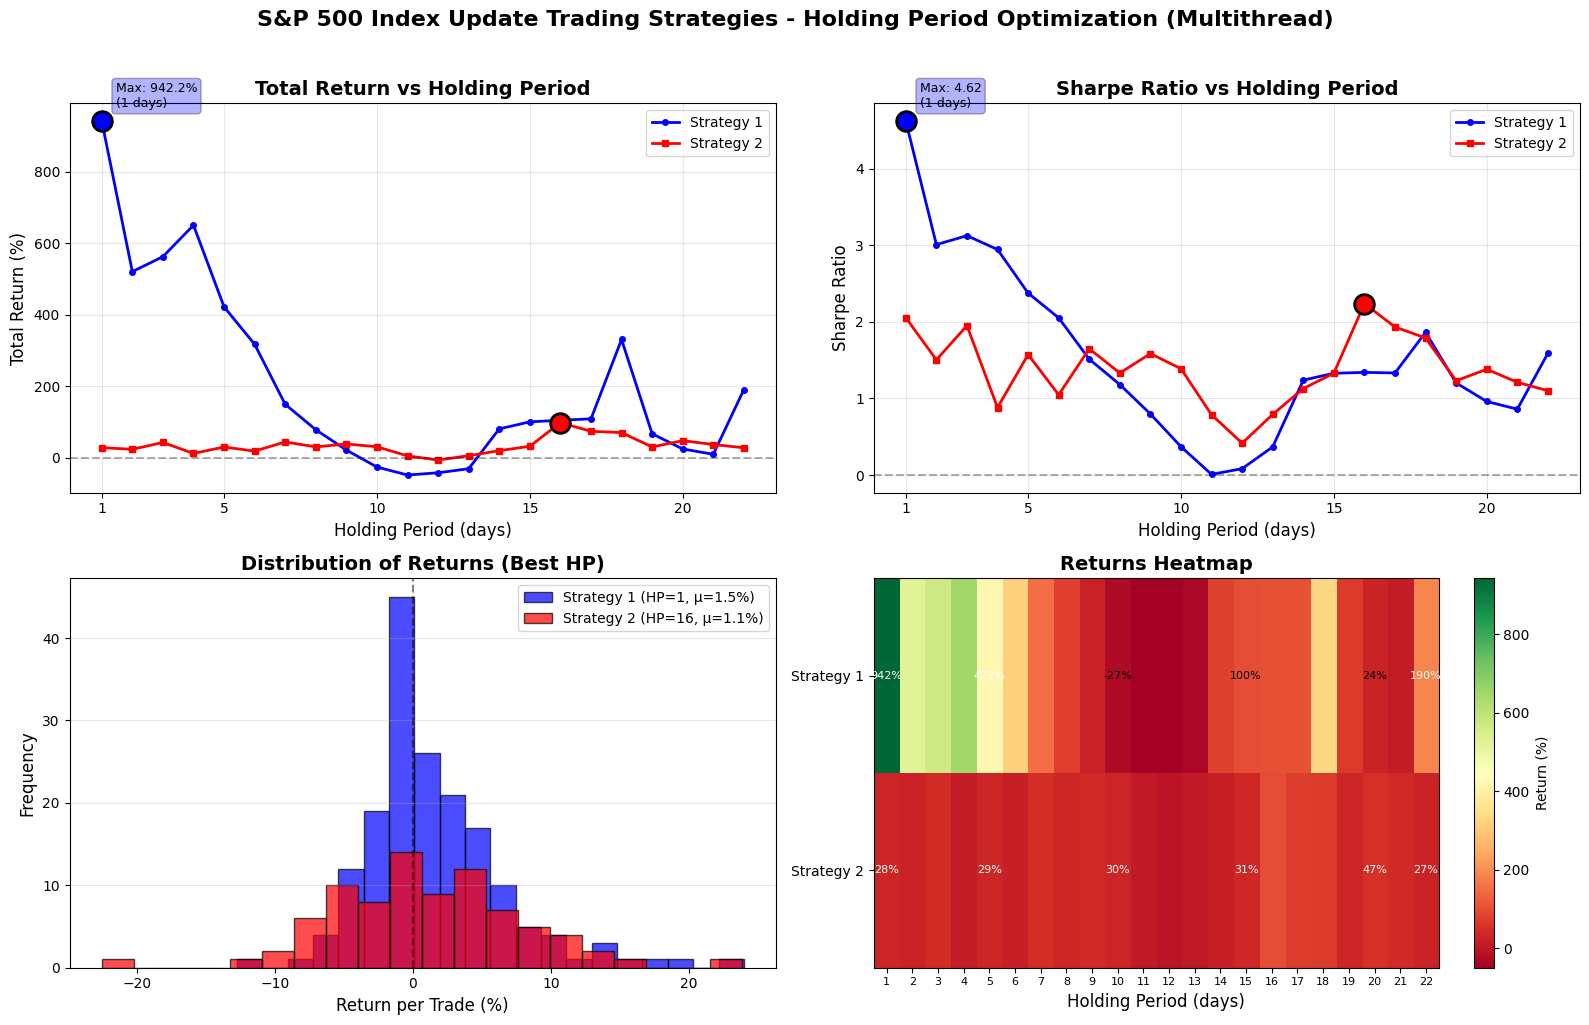

In [14]:
# Visualize holding period analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Total Returns vs Holding Period
ax1 = axes[0, 0]
ax1.plot(holding_periods, results['s1_returns'], marker='o', linewidth=2, 
         label='Strategy 1', color='blue', markersize=4)
ax1.plot(holding_periods, results['s2_returns'], marker='s', linewidth=2, 
         label='Strategy 2', color='red', markersize=4)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Holding Period (days)', fontsize=12)
ax1.set_ylabel('Total Return (%)', fontsize=12)
ax1.set_title('Total Return vs Holding Period', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks([1, 5, 10, 15, 20])

# Mark best points
s1_max_idx = np.argmax(results['s1_returns'])
s2_max_idx = np.argmax(results['s2_returns'])
ax1.scatter(holding_periods[s1_max_idx], results['s1_returns'][s1_max_idx], 
           color='blue', s=200, zorder=5, edgecolors='black', linewidth=2)
ax1.scatter(holding_periods[s2_max_idx], results['s2_returns'][s2_max_idx], 
           color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax1.annotate(f'Max: {results["s1_returns"][s1_max_idx]:.1f}%\n({holding_periods[s1_max_idx]} days)', 
            xy=(holding_periods[s1_max_idx], results['s1_returns'][s1_max_idx]),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))

# 2. Sharpe Ratio vs Holding Period
ax2 = axes[0, 1]
ax2.plot(holding_periods, results['s1_sharpe'], marker='o', linewidth=2, 
         label='Strategy 1', color='blue', markersize=4)
ax2.plot(holding_periods, results['s2_sharpe'], marker='s', linewidth=2, 
         label='Strategy 2', color='red', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Holding Period (days)', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Sharpe Ratio vs Holding Period', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks([1, 5, 10, 15, 20])

# Mark best Sharpe points
s1_sharpe_max_idx = np.argmax(results['s1_sharpe'])
s2_sharpe_max_idx = np.argmax(results['s2_sharpe'])
ax2.scatter(holding_periods[s1_sharpe_max_idx], results['s1_sharpe'][s1_sharpe_max_idx], 
           color='blue', s=200, zorder=5, edgecolors='black', linewidth=2)
ax2.scatter(holding_periods[s2_sharpe_max_idx], results['s2_sharpe'][s2_sharpe_max_idx], 
           color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax2.annotate(f'Max: {results["s1_sharpe"][s1_sharpe_max_idx]:.2f}\n({holding_periods[s1_sharpe_max_idx]} days)', 
            xy=(holding_periods[s1_sharpe_max_idx], results['s1_sharpe'][s1_sharpe_max_idx]),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))

# 3. Returns Distribution for Best Holding Period
ax3 = axes[1, 0]
best_s1_hp = holding_periods[s1_sharpe_max_idx]
best_s2_hp = holding_periods[s2_sharpe_max_idx]
best_s1_trades = all_portfolios[best_s1_hp]['s1_trades'] if best_s1_hp in all_portfolios else []
best_s2_trades = all_portfolios[best_s2_hp]['s2_trades'] if best_s2_hp in all_portfolios else []

if best_s1_trades:
    s1_returns_hist = [t['return'] * 100 for t in best_s1_trades]
    ax3.hist(s1_returns_hist, bins=20, alpha=0.7, 
             label=f'Strategy 1 (HP={best_s1_hp}, μ={np.mean(s1_returns_hist):.1f}%)', 
             color='blue', edgecolor='black')
if best_s2_trades:
    s2_returns_hist = [t['combined_return'] * 100 for t in best_s2_trades]
    ax3.hist(s2_returns_hist, bins=20, alpha=0.7, 
             label=f'Strategy 2 (HP={best_s2_hp}, μ={np.mean(s2_returns_hist):.1f}%)', 
             color='red', edgecolor='black')

ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Distribution of Returns (Best HP)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Return per Trade (%)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Heatmap of returns
ax4 = axes[1, 1]
comparison_data = np.array([results['s1_returns'], results['s2_returns']])
im = ax4.imshow(comparison_data, cmap='RdYlGn', aspect='auto', vmin=-50, vmax=max(results['s1_returns']))
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['Strategy 1', 'Strategy 2'])
ax4.set_xticks(range(len(holding_periods)))
ax4.set_xticklabels(holding_periods, fontsize=8)
ax4.set_xlabel('Holding Period (days)', fontsize=12)
ax4.set_title('Returns Heatmap', fontsize=14, fontweight='bold')

# Add text annotations for key holding periods
for i in [0, 4, 9, 14, 19, 21]:  # HP 1, 5, 10, 15, 20, 22
    if i < len(results['s1_returns']):
        ax4.text(i, 0, f'{results["s1_returns"][i]:.0f}%', ha='center', va='center', fontsize=8, 
                 color='white' if abs(results["s1_returns"][i]) > 100 else 'black')
        ax4.text(i, 1, f'{results["s2_returns"][i]:.0f}%', ha='center', va='center', fontsize=8, 
                 color='white' if abs(results["s2_returns"][i]) > 25 else 'black')

plt.colorbar(im, ax=ax4, label='Return (%)')

plt.suptitle('S&P 500 Index Update Trading Strategies - Holding Period Optimization (Multithread)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()